# Lux AI Season 2 Jupyter Notebook Tutorial - Python Kit

Welcome to Lux AI Season 2 Beta!

This notebook is the basic setup to use Jupyter Notebooks and the kaggle-environments package to develop your bot. If you plan to not use Jupyter Notebooks or any other programming language, please see our Github. The following are some important links!

Competition Page: https://www.kaggle.com/c/lux-ai-2022-beta/

Online Visualizer: https://2022vis.lux-ai.org/ (replays are only generatable via the CLI `luxai2022` tool at the moment)

Specifications: https://www.lux-ai.org/specs-2022-beta

Github: https://github.com/Lux-AI-Challenge/Lux-Design-2022

Bot API: https://github.com/Lux-AI-Challenge/Lux-Design-2022/tree/main/kits

And if you haven't done so already, we highly recommend you join our Discord server at https://discord.gg/aWJt3UAcgn or at the minimum follow the kaggle forums at https://www.kaggle.com/c/lux-ai-2022-beta/discussion. We post important announcements there such as changes to rules, events, and opportunities from our sponsors!

Now let's get started!

## Prerequisites
We assume that you have a basic knowledge of Python and programming. It's okay if you don't know the game specifications yet! Feel free to always refer back to https://www.lux-ai.org/specs-2022-beta.

## Basic Setup
First thing to verify is that you have python 3.7 or above and have the [luxai2022](https://pypi.org/project/luxai2022/) package installed

In [1]:
# # verify version
# !python --version
# # install luxai2022
# !pip install --upgrade luxai2022
# !pip install --upgrade moviepy # needed to render videos of episodes

In [2]:
# !cp -r ../input/lux-ai-2022-beta/* .

In [3]:
from luxai2022.env import LuxAI2022
import matplotlib.pyplot as plt
import numpy as np

We can now create an environment and start interacting with it, as well as look at what the observation is like

In [4]:
env = LuxAI2022() # create the environment object
obs = env.reset(seed=42) # resets an environment with a seed

In [5]:
# the observation is always composed of observations for both players.
obs.keys(), obs["player_0"].keys()

(dict_keys(['player_0', 'player_1']),
 dict_keys(['units', 'teams', 'factories', 'board', 'weather_schedule', 'real_env_steps']))

To visualize the environment, on jupyter notebooks you have two options

With the `rgb_array` mode you can visualize every step as an environment episode progresses

With `html` you can visualize episodes by providing a replay

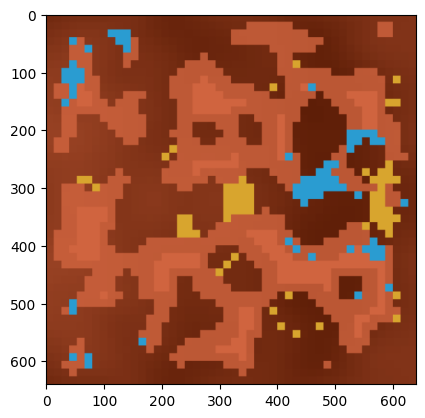

In [6]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

## Building an Agent
Now we know what the environment looks like, let's try building a working agent. The goal of this environment to ensure at least one factory stays alive by the end of the episode and grow as much lichen as possible.

In our kit we provide a skeleton for building an agent. Avoid removing any function from the kit unless you know what you are doing as it may cause your agent to fail on the competition servers. This agent defintion should be stored in the `agent.py` file.

The agent will have `self.player, self.opp_player, self.env_cfg` populated with the correct values at each step of an environment during competition or when you use the CLI tool to run matches. 

`self.env_cfg` stores the curent environment's configurations, and `self.player, self.opp_player` stores the name of your player/team and the opposition respectively (will always be "player_0" or "player_1").

In [7]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai2022.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        # optionally convert observations to python objects with utility functions
        game_state = obs_to_game_state(step, self.env_cfg, obs) 
        return actions

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        return actions

Note that in season 2, there are two distinct phases of the game where you will have to program two different sets of logic to play it.
 
We willalso define a simple function to initialize our agent and interact with the environment and generate a simple video replay.
No need to worry about how this works specifically, you can copy paste this as you see fit. Note that this is a simplified representation. In order to visually see all numbers and details about units, factories etc. use our web visualizer.

In [8]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs = env.reset(seed=41)
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

### Early Phase

In the Early Phase, you must enter a bid (≥ 0) for a new factory, declare a faction, and place your factories onto your side of the map. We will write a simple `early_setup` function to return the appropriate action to handle this phase.

At timestep 0, you place a bid in addition to declaring a faction (this is something that we will be using for the official release, it will not affect gameplay at anytime). Each unit of bidding removes 1 water and 1 metal from your starting pool of water and metal.

Each team gets `N` factories to place, with the winning bidder (if there is one) getting `N+1` factories. For the next `N+1` steps both teams get to place factories anywhere on their own half. For conveniency the observation contains all possible spawn locations for your team

In [11]:
def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
    if step == 0:
        # bid 0 to not waste resources bidding and declare as the default faction
        # you can bid -n to prefer going second or n to prefer going first in placement
        return dict(faction="AlphaStrike", bid=0)
    else:
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        # factory placement period
        
        # how much water and metal you have in your starting pool to give to new factories
        water_left = game_state.teams[self.player].water
        metal_left = game_state.teams[self.player].metal
        
        # how many factories you have left to place
        factories_to_place = game_state.teams[self.player].factories_to_place
        # whether it is your turn to place a factory
        my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
        if factories_to_place > 0 and my_turn_to_place:
            # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
            potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
            spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
            return dict(spawn=spawn_loc, metal=150, water=150)
        return dict()
Agent.early_setup = early_setup

Now let's observe what happens when we run this early setup function for each agent.

In [12]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 5)

GameState(env_steps=1, env_cfg=EnvConfig(max_episode_length=1000, map_size=48, verbose=1, validate_action_space=True, max_transfer_amount=10000, MIN_FACTORIES=2, MAX_FACTORIES=5, CYCLE_LENGTH=50, DAY_LENGTH=30, UNIT_ACTION_QUEUE_SIZE=20, MAX_RUBBLE=100, FACTORY_RUBBLE_AFTER_DESTRUCTION=50, INIT_WATER_METAL_PER_FACTORY=150, INIT_POWER_PER_FACTORY=1000, MIN_LICHEN_TO_SPREAD=10, LICHEN_LOST_WITHOUT_WATER=1, LICHEN_GAINED_WITH_WATER=1, MAX_LICHEN_PER_TILE=100, LICHEN_WATERING_COST_FACTOR=10, BIDDING_SYSTEM=True, FACTORY_PROCESSING_RATE_WATER=50, ICE_WATER_RATIO=2, FACTORY_PROCESSING_RATE_METAL=50, ORE_METAL_RATIO=5, FACTORY_CHARGE=50, FACTORY_WATER_CONSUMPTION=1, ROBOTS={'LIGHT': UnitConfig(METAL_COST=10, POWER_COST=50, CARGO_SPACE=100, BATTERY_CAPACITY=150, CHARGE=1, INIT_POWER=50, MOVE_COST=1, RUBBLE_MOVEMENT_COST=0, DIG_COST=5, DIG_RUBBLE_REMOVED=2, DIG_RESOURCE_GAIN=2, DIG_LICHEN_REMOVED=10, SELF_DESTRUCT_COST=5, RUBBLE_AFTER_DESTRUCTION=1, ACTION_QUEUE_POWER_COST=1), 'HEAVY': UnitConf

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Congratz, we have lift off! We got both teams to spawn some factories. With the early phase over, we can now start programming the logic to power the next phase.

### Regular Phase

The goal of the game is to grow more lichen than your opponent by the end of the 1000 step episode (not including early phase steps). To grow lichen factories must consume water. Moreover, factories passively consume 1 water a turn, and you must ensure at least one factory survives until the end. Whichever team loses all their factories first will automatically lose. 

To obtain water, robots/units must mine ice from ice tiles (blue on the map) and deliver them back to a factory which then automatically refines ice into water. 

Moreover, to help us write better code, we will use the provided function `obs_to_game_state` to convert observations from raw dictionaries to interactable python objects. Finally, we will also use a provided `animate` function to easily generate a simple video of the episode and embed it into here without having to upload a replay file to the web visualizer.

#### Building Robots

Only factories can build robots, so for each factory on our team, if there is enough metal and power, we will issue a command to build a new heavy robot.

More advanced strategies will be able to efficiently leverage light units as well to collect resources but for simplicity, this tutorial uses heavy robots since they don't need to move as often to collect many resources (albeit very energy inefficient).

In [23]:
from lux.kit import obs_to_game_state, GameState

In [24]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
    return actions
Agent.act = act

In [25]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 25)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Robots built, but they're idle! Let's get them to work.

#### Moving Robots and Mining

We want the robots to find the closest ice tile and mine it.
We'll worry about delivering the ice back home later. Let's update our `act` function to add this functionality. We will iterate over all our units and find the closest ice tile. Then we will use a given utility function that gives us the direction that takes us towards the desired ice tile. Lastly, we check if we have enough power to move and can move in that direction and submit that action.

Importantly, in this season **units are given action queues (a list of actions). Each time an action queue is given, the unit's old action queue is replaced completely in addition to a small additional action queue submission power cost.**

**Moreover, each action can be set to be repeated or not, indicating whether to put the action to the back of the queue once completed** For this tutorial, we will be giving units one action at a time and setting it to not be repeated. For future reference, to reduce power costs you can submit longer action queues and only update the action queue every once in a while.

In [29]:
from lux.utils import direction_to
import sys
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
            
    # iterate over our units and have them mine the closest ice tile
    units = game_state.units[self.player]
    ice_map = game_state.board.ice # flip the board as it stores by rows then columns
    ice_tile_locations = np.argwhere(ice_map == 1) # numpy magic to get the position of every ice tile
    for unit_id, unit in units.items():
        # compute the distance to each ice tile from this unit and pick the closest
        ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
        closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
        
        # if we have reached the ice tile, start mining if possible
        if np.all(closest_ice_tile == unit.pos):
            if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.dig(repeat=0)]
        else:
            direction = direction_to(unit.pos, closest_ice_tile)
            move_cost = unit.move_cost(game_state, direction)
            # check move_cost is not None, meaning that direction is not off the map or blocked
            # check if unit has enough power to move in addition to updating the action queue.
            if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.move(direction, repeat=0)]
        # since we are using the simple embedded visualizer, we will have to print out details about units
        # importantly, note that we print with file=sys.stderr. Printing with anything will cause your agent to fail
        if unit.cargo.ice > 50:
            print(game_state.real_env_steps, unit, f"has {unit.cargo.ice} ice", file=sys.stderr)
    return actions
Agent.act = act

In [30]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, steps=40)

7 [0] unit_5 HEAVY at [43 29] has 60 ice
8 [0] unit_5 HEAVY at [43 29] has 60 ice
9 [0] unit_5 HEAVY at [43 29] has 60 ice
10 [0] unit_5 HEAVY at [43 29] has 60 ice
11 [0] unit_5 HEAVY at [43 29] has 60 ice
12 [0] unit_5 HEAVY at [43 29] has 60 ice
13 [0] unit_5 HEAVY at [43 29] has 60 ice
14 [0] unit_5 HEAVY at [43 29] has 80 ice
15 [0] unit_5 HEAVY at [43 29] has 80 ice
16 [0] unit_5 HEAVY at [43 29] has 80 ice
17 [0] unit_5 HEAVY at [43 29] has 80 ice
18 [0] unit_5 HEAVY at [43 29] has 80 ice
19 [0] unit_5 HEAVY at [43 29] has 80 ice
20 [0] unit_5 HEAVY at [43 29] has 80 ice
21 [0] unit_5 HEAVY at [43 29] has 80 ice
21 [1] unit_6 HEAVY at [19  2] has 60 ice
22 [0] unit_4 HEAVY at [19 45] has 60 ice
22 [0] unit_5 HEAVY at [43 29] has 80 ice
22 [1] unit_6 HEAVY at [19  2] has 60 ice
23 [0] unit_4 HEAVY at [19 45] has 60 ice
23 [0] unit_5 HEAVY at [43 29] has 80 ice
23 [1] unit_6 HEAVY at [19  2] has 60 ice
24 [0] unit_4 HEAVY at [19 45] has 60 ice
24 [0] unit_5 HEAVY at [43 29] has 80

And they're off! The heavy robots have started to move towards the ice tiles and some have begun mining.

#### Delivering Resources and Keep Factories Alive
We now have ice being mined, but we now need to deliver that back to the factories so they can refine that ice into water and sustain themselves.

In [31]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    for unit_id, unit in units.items():
        
        # track the closest factory
        closest_factory = None
        adjacent_to_factory = False
        if len(factory_tiles) > 0:
            factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
            closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
            closest_factory = factory_units[np.argmin(factory_distances)]
            adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0
        
            # previous ice mining code
            if unit.cargo.ice < 40:
                ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                if np.all(closest_ice_tile == unit.pos):
                    if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.dig(repeat=0)]
                else:
                    direction = direction_to(unit.pos, closest_ice_tile)
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
            # else if we have enough ice, we go back to the factory and dump it.
            elif unit.cargo.ice >= 40:
                direction = direction_to(unit.pos, closest_factory_tile)
                if adjacent_to_factory:
                    if unit.power >= unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                else:
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
    return actions
Agent.act = act

In [32]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 300)

190: player_1 lost all factories


OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Some factories are surviving for for more than 100 steps thanks to the delivery of additional ice, but more work will need to be done to keep them alive longer.

Puting all those pieces together the full starter agent looks like this (and we will save it to agent.py)

In [18]:
%%writefile agent.py
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            # bid 0 to not waste resources bidding and declare as the default faction
            return dict(faction="AlphaStrike", bid=0)
        else:
            game_state = obs_to_game_state(step, self.env_cfg, obs)
            # factory placement period

            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal

            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        game_state.teams[self.player].place_first
        factory_tiles, factory_units = [], []
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
            if self.env_cfg.max_episode_length - game_state.real_env_steps < 50:
                if factory.water_cost(game_state) <= factory.cargo.water:
                    actions[unit_id] = factory.water()
            factory_tiles += [factory.pos]
            factory_units += [factory]
        factory_tiles = np.array(factory_tiles)

        units = game_state.units[self.player]
        ice_map = game_state.board.ice
        ice_tile_locations = np.argwhere(ice_map == 1)
        for unit_id, unit in units.items():

            # track the closest factory
            closest_factory = None
            adjacent_to_factory = False
            if len(factory_tiles) > 0:
                factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
                closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
                closest_factory = factory_units[np.argmin(factory_distances)]
                adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0

                # previous ice mining code
                if unit.cargo.ice < 40:
                    ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                    closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                    if np.all(closest_ice_tile == unit.pos):
                        if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.dig(repeat=0)]
                    else:
                        direction = direction_to(unit.pos, closest_ice_tile)
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
                # else if we have enough ice, we go back to the factory and dump it.
                elif unit.cargo.ice >= 40:
                    direction = direction_to(unit.pos, closest_factory_tile)
                    if adjacent_to_factory:
                        if unit.power >= unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                    else:
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
        return actions

Overwriting agent.py


## Create a submission
Now we need to create a .tar.gz file with main.py (and agent.py) at the top level. We can then upload this!

In [19]:
!tar -czf submission.tar.gz *

## Submit
Now open the /kaggle/working folder and find submission.tar.gz, download that file, navigate to the "MySubmissions" tab in https://www.kaggle.com/c/lux-ai-2022-beta/ and upload your submission! It should play a validation match against itself and once it succeeds it will be automatically matched against other players' submissions. Newer submissions will be prioritized for games over older ones. Your team is limited in the number of succesful submissions per day so we highly recommend testing your bot locally before submitting.

## CLI Tool

To test your agent without using the python API you can also run

In [20]:
!luxai2022 main.py main.py -v 2 -s 101 -o replay.json

122: 1 Units: (unit_10) collided at 4,40 with [0] unit_6 UnitType.HEAVY at (4, 40) surviving
150: player_0 lost all factories
150: player_1 lost all factories
0.7056684494018555


which uses a random seed and generates a replay.json file that you can upload and watch at http://2022vis.lux-ai.org/.

This is the only way to generate replay files at the moment that can viewed in the full-scale visualizer (which includes all information like unit cargo, weather, and more).


The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-2022/tree/main/luxai_runner/README.md

## Suggestions / Strategies

This starter agent is very barebones and simply controls your agent to mine the nearest ice and deliver it back to try and keep factories alive.

There are a number of simple strategies you can try and implement to easily increase survivability and eventually grow lichen to score points

- Pickup power from nearby friendly factories. Factories generate 50 power per turn and this is a ton of power that your units can pickup with the `pickup` action to then use to travel around and mine more resources. Try adding this to the starter agent, it will enable your agent to survive to the end and grow lots of lichen.

- Better factory placement. Placing factories randomly is not optimal, try placing factories right next to ice or metal tiles, reducing travel time and increasing the number of resources delivered and refined.

- Grow lichen at the end of the game. Lichen costs water to both increase and maintain, so you can save water until the end of the game and then grow lichen as fast as possible.

Some more intermediate strategies include

- Building light robots and ensuring they don't collide with other units

- Mining metal and building light/heavy robots

Some more advanced strategies include

- Using Light units to deliver resources from factory to factory, especially if some factories are closer to ice or metal tiles

- Sending light and heavy robots to the opponents side to disrupt their mining and lichen

- Leveraging the marsquake to send light robots to the opponents side to drop rubble all over their lichen.

Good luck!